#### - Sobhan Moradian Daghigh
#### - 12/27/2021
#### - PR - EX02 - Q6 - All Parts

In [161]:
import numpy as np
from PIL import Image
import os
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [2]:
def get_data_paths(directory):
    filePaths = []
    for dirpath,_,filenames in os.walk(directory):
        for image_name in filenames:
            filePaths.append(os.path.abspath(os.path.join(dirpath, image_name))) 
    return filePaths

In [3]:
train = get_data_paths("./inputs/P6/pratheepan/train/set1/images")
train_masks = get_data_paths("./inputs/P6/pratheepan/train/set1/groundtruth")

### Part A.

In [4]:
skinPixelCounts = [[[0 for k in range(256)] for j in range(256)] for i in range(256)]
noskinPixelCounts = [[[0 for k in range(256)] for j in range(256)] for i in range(256)]

# For next step, calculating the mean and covariance matrix
skin_list = []
noSkin_list = []

for i in range(len(train)):
    img = Image.open(train[i]).convert('RGB')
    mask = Image.open(train_masks[i]).convert('RGB')
    w, h = img.size
    
    for j in range(h):
        for i in range(w):
            red, green, blue = img.getpixel((i, j))
            maskRed, maskGreen, maskBlue = mask.getpixel((i, j))

            if(maskRed > 150 and maskGreen > 150 and maskBlue > 150):
                skinPixelCounts[red][green][blue] += 1
                skin_list.append([red, green, blue])
            else:
                noskinPixelCounts[red][green][blue] += 1
                noSkin_list.append([red, green, blue])
                
                
    img.close()
    mask.close()

In [5]:
def nested_sum(L):
    total = 0
    for i in L:
        if isinstance(i, list):
            total += nested_sum(i)
        else:
            total += i
    return total

In [6]:
# Skin Pixels Frequency
skin_count = nested_sum(skinPixelCounts)

In [7]:
# NoSkin Pixels Frequency
noSkin_count = nested_sum(noskinPixelCounts)

In [8]:
# Sum of pixels
pix_count = np.add(skin_count, noSkin_count)

#### Skin Prior Probability

In [145]:
skin_prior = round(np.divide(skin_count, pix_count), 3)
skin_prior

0.275

#### NoSkin Prior Probability

In [146]:
noSkin_prior = round(np.divide(noSkin_count, pix_count), 3)
noSkin_prior

0.725

### Part B.

In [127]:
def get_mean(datas):
    mean = np.divide([sum(x) for x in zip(*datas)], len(datas))
    # The dimention is too high, so Im not wanna calculate in matrix form
    # cov = np.matmul([np.subtract(x, mean) for x in datas], np.transpose([np.subtract(x, mean) for x in datas]))
    temp = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    for ele in datas:
        sub = np.subtract(ele, mean).reshape(3, 1)
        temp = np.add(temp, np.matmul(np.array(sub), np.transpose(np.array(sub))))
    cov = np.divide(temp, len(datas))
    return mean, cov

#### Skin Mean and Covariance

In [139]:
skin_mean, skin_cov = get_mean(skin_list)
print("Mean: \n{}".format(skin_mean))
print("\nCovariance: \n{}".format(skin_cov))

Mean: 
[189.93650938 140.48149646 111.69942265]

Covariance: 
[[1962.10616042 1953.49144369 1861.1339192 ]
 [1953.49144369 2383.49106594 2449.30086464]
 [1861.1339192  2449.30086464 2675.40603824]]


In [140]:
# Check for [det != 0] 
# If [det == 0], then its a singular Covariance and theres no inverse for it.
np.linalg.det(skin_cov)

85364096.30087139

#### NoSkin Mean and Covariance

In [141]:
noSkin_mean, noSkin_cov = get_mean(noSkin_list)
print("Mean: \n{}".format(noSkin_mean))
print("\nCovariance: \n{}".format(noSkin_cov))

Mean: 
[129.37221255 106.52092805  96.43530788]

Covariance: 
[[7762.2423282  6717.72306037 6294.89032932]
 [6717.72306037 7075.67355209 6916.65215675]
 [6294.89032932 6916.65215675 7145.14202326]]


In [142]:
# Check for [det != 0] 
# If [det == 0], then its a singular Covariance and theres no inverse for it.
np.linalg.det(noSkin_cov)

3237844884.813418

### Part C.

In [224]:
# Continues with Noraml Distribution
def cal_probability_density(mean, cov, x):
    var = multivariate_normal(mean=mean, cov=cov)
    prob = var.pdf(x)
    return prob

In [323]:
def BC(skin_liklihood, noSkin_liklihood, thresh=0.0):
    predictions = []

    for skn, noSkn in zip(skin_liklihood, noSkin_liklihood):
        posteriors = []
        
        posteriors.append(np.add(np.add(np.log(skin_prior), np.log(skn)), np.log2((thresh * 10) + 1)))
        posteriors.append(np.add(np.log(noSkin_prior), np.log(noSkn)))
    
        idx = np.argmax(posteriors)
        predictions.append(0 if idx == 1 else 255)
        
    return predictions

In [306]:
def skinDetection(img_name, thresh):
    
    img = Image.open(img_name).convert('RGB')
    w, h = img.size
    blank = np.zeros((h, w), dtype=int)

    for j in range(h):
        skin_liklihood = cal_probability_density(skin_mean, skin_cov, np.array(img)[j])
        noSkin_liklihood = cal_probability_density(noSkin_mean, noSkin_cov, np.array(img)[j])
        blank[j] = BC(skin_liklihood, noSkin_liklihood, thresh)

    return blank

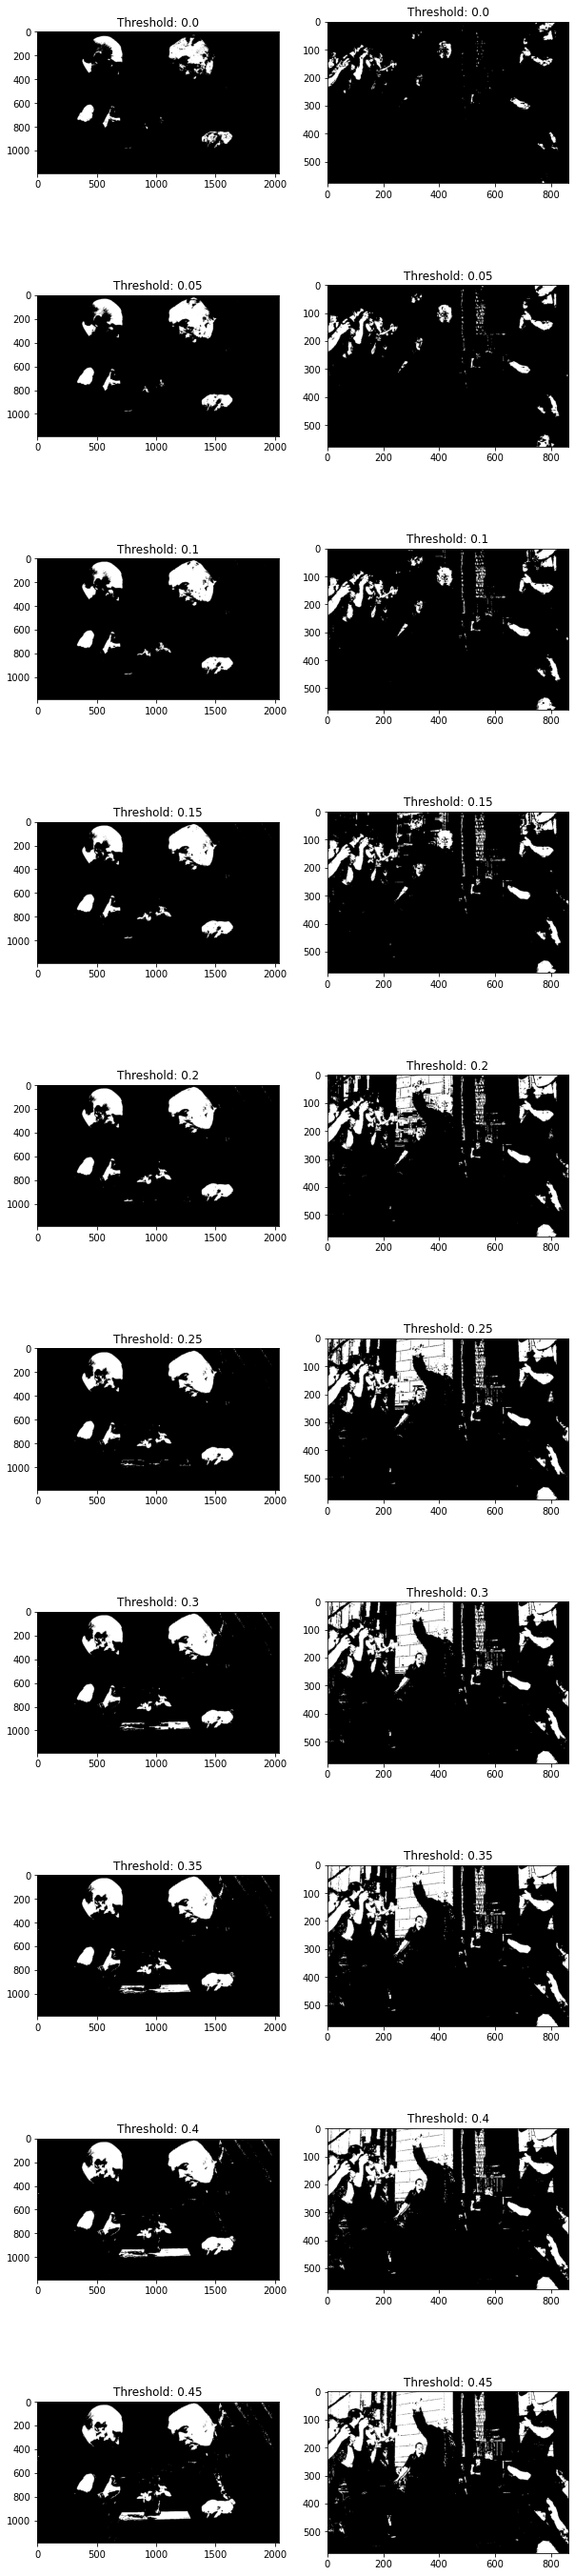

In [349]:
fig, ax = plt.subplots(10, 2, figsize=(10, 50))
images = ['trump_tie_1.jpg', 'trump_tie_2.jpg']

for i in range(2):
    img_name = './inputs/P6/{}'.format(images[i])
    idx = 0
    for thresh in np.arange(0.0, 0.5, 0.05):
        thresh = round(thresh, 2)
        blank = skinDetection(img_name, thresh)
        ax[idx, i].imshow(blank, cmap='gray')
        ax[idx, i].set_title('Threshold: {}'.format(thresh))
        idx += 1

plt.show()

In [ ]:


skinPixels = 0
nonSkinPixels = 0

for i in range(256):
  for j in range(256):
    for k in range(256):
      skinPixelNumber[i][j][k] += 1
      skinPixels += skinPixelNumber[i][j][k]
      nonskinPixelNumber[i][j][k] += 1
      nonSkinPixels += nonskinPixelNumber[i][j][k]
  print("^", end="")
probabilityOfSkin = skinPixels / (skinPixels + nonSkinPixels)
probability = 0

f = open("./noesis.sadi", 'w')
f.write("")
for i in range(256):
  for j in range(256):
    for k in range(256):
      probability = skinPixelNumber[i][j][k] * probabilityOfSkin / (skinPixelNumber[i][j][k] + nonskinPixelNumber[i][j][k])
      f.write(str(probability) + "\n")
  print("*", end="")

f.close()

In [ ]:
from PIL import Image

ratio = [[[0 for k in range(256)] for j in range(256)] for i in range(256)]

with open("./noesis.sadi", "r") as file:
  for i in range(256):
    for j in range(256):
      for k in range(256):
        probability = file.readline()
        ratio[i][j][k] = float(probability)
print('data collected!')

image = Image.open("./inputs/P6/pratheepan/test/images/m(01-32)_gr.jpg")
im = image.convert('RGB')
width, height = im.size

im2 = Image.new(im.mode, im.size)

for y in range(height):
  for x in range(width):
    red, green, blue = im.getpixel((x, y))
    if(ratio[red][green][blue] > .25):
      im2.putpixel((x, y), (255, 255, 255))
    else:
      im2.putpixel((x, y), (0, 0, 0))
  print("*", end="")

im2.save("./detected4.jpg")
# im2.show()